# normal

In [6]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from scipy.signal import detrend
from statsmodels.stats.diagnostic import acorr_ljungbox
from astropy.timeseries import LombScargle

# --- 1. load and pre-process -------------------------------------------------
df = (
    pd.read_excel("./data/d18O NGRIP 21.04.24.xlsx",
                  sheet_name="Raw Data",
                  usecols="C:D",
                  skiprows=10, nrows=6114, names=["Age", "d18o"])
      .query("Age < 10000")
)

t = df["Age"].values
y = detrend(df["d18o"].values)
residual = y.copy()

harms = []

# --- 2. function to estimate init guesses ------------------------------------
def estimate_initial_params(t, y, n_peaks=1):
    frequency, power = LombScargle(t, y).autopower(minimum_frequency=1/10000,
                                                   maximum_frequency=1/100,
                                                   samples_per_peak=10)
    idx = np.argsort(power)[-n_peaks:][::-1]
    freq_guesses = frequency[idx]
    period_guesses = 1 / freq_guesses

    amps, phis = [], []
    for f in freq_guesses:
        X = np.column_stack([np.sin(2 * np.pi * f * t),
                             np.cos(2 * np.pi * f * t)])
        coeff, *_ = np.linalg.lstsq(X, y, rcond=None)
        a, b = coeff
        A = np.hypot(a, b)
        phi = np.arctan2(b, a)
        amps.append(A)
        phis.append(phi)

    return period_guesses, np.array(amps), np.array(phis)

# --- 3. iterative fit --------------------------------------------------------
for k in range(10):  # Just one iteration for now; expand later if needed
    P_init, A_init, phi_init = estimate_initial_params(t, residual, n_peaks=1)

    # --- SAFETY CHECKS ---
    if np.isnan(P_init[0]) or P_init[0] < 200 or P_init[0] > 10000:
        print(f"Iteration {k+1}: Bad period guess ({P_init[0]}), using fallback")
        P_init[0] = 1000  # Fallback period

    if np.isnan(phi_init[0]) or np.isinf(phi_init[0]):
        print(f"Iteration {k+1}: Bad phase guess, clamping to π")
        phi_init[0] = np.pi  # Fallback phase

    phi_init = np.clip(phi_init[0], 0.001, 2 * np.pi - 0.001)  # Avoid boundaries

    print(f"Iteration {k+1} – Using initial values:")
    print(f"  Period: {P_init[0]:.1f}, Amplitude: {A_init[0]:.3f}, Phase: {phi_init:.3f}")

    # --- PYMC MODEL ---
    with pm.Model() as mod:
        P = pm.TruncatedNormal("P", mu=P_init[0], sigma=300, lower=200, upper=11000)
        A = pm.HalfNormal("A", sigma=A_init[0]*2)
        phi = pm.Uniform("phi", lower=0, upper=2*np.pi)
        sigma = pm.HalfNormal("sigma", sigma=1.0)

        mu = A * pm.math.sin(2*np.pi*t / P + phi)
        pm.Normal("obs", mu=mu, sigma=sigma, observed=residual)

        # Use same initial values for all 4 chains

phi_init_clipped = np.clip(phi_init[0], 0.001, 2 * np.pi - 0.001)

initvals = [
    {
        "P": P_init[0] + np.random.normal(0, 50),
        "A": A_init[0] + np.random.normal(0, 0.05),
        "phi": np.clip(
            phi_init_clipped + np.random.normal(0, 0.1),  # add noise
            0.001,                                         # lower bound
            2 * np.pi - 0.001                              # upper bound
        ),
        "sigma": np.std(residual) + np.random.normal(0, 0.01)
    } for _ in range(8)
]
        try:
            tr = pm.sample(
                draws=4000,
                tune=4000,
                chains=8,               
                target_accept=0.98,     # <-- optional: reduce divergences
                initvals=initvals,
                progressbar=True
            )
        except pm.SamplingError as e:
            print("⚠️ Sampling failed with initial values:")
            print(initvals)
            print("Model debug info:")
            mod.debug()
            break

    # Diagnostics
    print(az.summary(tr))

    P_hat, A_hat, phi_hat = (tr.posterior[var].mean().item() for var in ("P", "A", "phi"))

    residual -= A_hat * np.sin(2*np.pi*t / P_hat + phi_hat)
    harms.append((P_hat, A_hat, phi_hat))

    pvals = acorr_ljungbox(residual, lags=[10, 50, 100], return_df=True)["lb_pvalue"]
    if (pvals > 0.05).all():
        print(f"Stopped after {k+1} harmonics – residual looks like noise.")
        break

# --- 4. report + plot --------------------------------------------------------
print("\nExtracted harmonics:")
for i, (P_, A_, ph_) in enumerate(harms, 1):
    print(f"{i:2d}:  P = {P_:>7.0f} yr   A = {A_:>6.3f}   ϕ = {ph_:>5.2f} rad")

plt.figure(figsize=(12,4))
plt.plot(t, y,            label="Detrended data", alpha=0.5)
plt.plot(t, y - residual, label="Sum of fitted harmonics", color="red")
plt.plot(t, residual,     label="Residual", alpha=0.6)
plt.legend()
plt.xlabel("Age (yr BP)")
plt.ylabel("δ18O (detrended)")

plt.title("Iterative Bayesian harmonic fit")
plt.tight_layout()
plt.show()

IndentationError: unindent does not match any outer indentation level (<string>, line 108)

In [ ]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from scipy.signal import detrend
from statsmodels.stats.diagnostic import acorr_ljungbox
from astropy.timeseries import LombScargle

# --- 1. load and pre-process -------------------------------------------------
df = (
    pd.read_excel("./data/d18O NGRIP 21.04.24.xlsx",
                  sheet_name="Raw Data",
                  usecols="C:D",
                  skiprows=10, nrows=6114, names=["Age", "d18o"])
      .query("Age < 10000")
)

t = df["Age"].values
y = detrend(df["d18o"].values)
residual = y.copy()

harms = []

# --- 2. function to estimate init guesses ------------------------------------
def estimate_initial_params(t, y, n_peaks=1):
    frequency, power = LombScargle(t, y).autopower(minimum_frequency=1/10000,
                                                   maximum_frequency=1/100,
                                                   samples_per_peak=10)
    idx = np.argsort(power)[-n_peaks:][::-1]
    freq_guesses = frequency[idx]
    period_guesses = 1 / freq_guesses

    amps, phis = [], []
    for f in freq_guesses:
        X = np.column_stack([np.sin(2 * np.pi * f * t),
                             np.cos(2 * np.pi * f * t)])
        coeff, *_ = np.linalg.lstsq(X, y, rcond=None)
        a, b = coeff
        A = np.hypot(a, b)
        phi = np.arctan2(b, a)
        amps.append(A)
        phis.append(phi)

    return period_guesses, np.array(amps), np.array(phis)

# --- 3. iterative fit --------------------------------------------------------
for k in range(10):  # Just one iteration for now; expand later if needed
    P_init, A_init, phi_init = estimate_initial_params(t, residual, n_peaks=1)

    # --- SAFETY CHECKS ---
    if np.isnan(P_init[0]) or P_init[0] < 200 or P_init[0] > 10000:
        print(f"Iteration {k+1}: Bad period guess ({P_init[0]}), using fallback")
        P_init[0] = 1000  # Fallback period

    if np.isnan(phi_init[0]) or np.isinf(phi_init[0]):
        print(f"Iteration {k+1}: Bad phase guess, clamping to π")
        phi_init[0] = np.pi  # Fallback phase

    phi_init_clipped = np.clip(phi_init[0], 0.001, 2 * np.pi - 0.001)

    print(f"Iteration {k+1} – Using initial values:")
    print(f"  Period: {P_init[0]:.1f}, Amplitude: {A_init[0]:.3f}, Phase: {phi_init_clipped:.3f}")

    # --- PYMC MODEL ---
    with pm.Model() as mod:
        P = pm.TruncatedNormal("P", mu=P_init[0], sigma=300, lower=200, upper=11000)
        A = pm.HalfNormal("A", sigma=A_init[0]*2)
        phi = pm.Uniform("phi", lower=0, upper=2*np.pi)
        sigma = pm.HalfNormal("sigma", sigma=1.0)

        mu = A * pm.math.sin(2*np.pi*t / P + phi)
        pm.Normal("obs", mu=mu, sigma=sigma, observed=residual)

        # Use randomized initial values per chain, safely clipped
        np.random.seed(42)  # Optional: for reproducibility
        initvals = [
            {
                "P": np.clip(P_init[0] + np.random.normal(0, 50), 200, 10000),
                "A": max(0.001, A_init[0] + np.random.normal(0, 0.05)),
                "phi": np.clip(phi_init_clipped + np.random.normal(0, 0.1), 0.001, 2*np.pi - 0.001),
                "sigma": max(0.001, np.std(residual) + np.random.normal(0, 0.01))
            } for _ in range(8)
        ]

        try:
            tr = pm.sample(
                draws=4000,
                tune=4000,
                chains=8,
                target_accept=0.98,
                initvals=initvals,
                progressbar=True
            )
        except pm.SamplingError as e:
            print("⚠️ Sampling failed with initial values:")
            print(initvals)
            print("Model debug info:")
            mod.debug()
            break

    # Diagnostics
    print(az.summary(tr))

    P_hat, A_hat, phi_hat = (tr.posterior[var].mean().item() for var in ("P", "A", "phi"))

    residual -= A_hat * np.sin(2*np.pi*t / P_hat + phi_hat)
    harms.append((P_hat, A_hat, phi_hat))

    pvals = acorr_ljungbox(residual, lags=[10, 50, 100], return_df=True)["lb_pvalue"]
    if (pvals > 0.05).all():
        print(f"Stopped after {k+1} harmonics – residual looks like noise.")
        break

# --- 4. report + plot --------------------------------------------------------
print("\nExtracted harmonics:")
for i, (P_, A_, ph_) in enumerate(harms, 1):
    print(f"{i:2d}:  P = {P_:>7.0f} yr   A = {A_:>6.3f}   ϕ = {ph_:>5.2f} rad")

plt.figure(figsize=(12,4))
plt.plot(t, y,            label="Detrended data", alpha=0.5)
plt.plot(t, y - residual, label="Sum of fitted harmonics", color="red")
plt.plot(t, residual,     label="Residual", alpha=0.6)
plt.legend()
plt.xlabel("Age (yr BP)")
plt.ylabel("δ18O (detrended)")
plt.title("Iterative Bayesian harmonic fit")
plt.tight_layout()
plt.show()

Iteration 1 – Using initial values:
  Period: 10000.0, Amplitude: 0.201, Phase: 0.001


Initializing NUTS using jitter+adapt_diag...
C:\Users\Francesco\AppData\Roaming\Python\Python312\site-packages\pytensor\link\c\cmodule.py:2959: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library
  warnings.warn(
Multiprocess sampling (8 chains in 4 jobs)
NUTS: [P, A, phi, sigma]


KeyboardInterrupt: 

In [ ]:
from astropy.visualization import plot_periodogram

fig, ax = plt.subplots(figsize=(12, 6))
plot_periodogram(frequency, power, ax=ax, draw_style="line")
ax.set_xscale("log")
ax.set_xlim(1e-4, 1e-2)  # corresponds to periods ~100–10,000 yr
ax.set_title("Lomb-Scargle Periodogram")
plt.xlabel("Frequency (1/yr)")
plt.ylabel("Power")
plt.grid(True)
plt.show()


ImportError: cannot import name 'plot_periodogram' from 'astropy.visualization' (C:\ProgramData\anaconda3\Lib\site-packages\astropy\visualization\__init__.py)

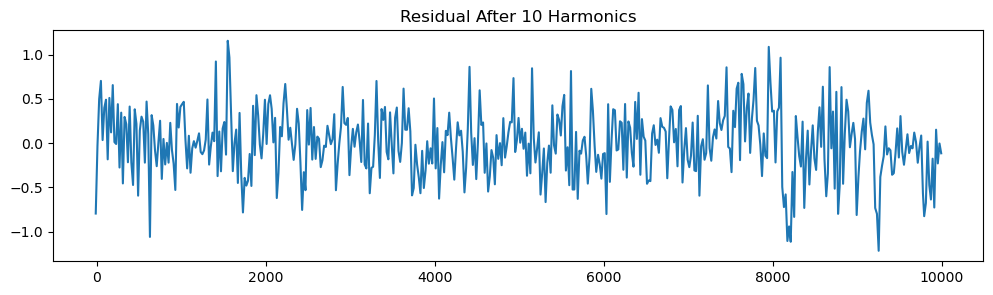

In [ ]:
plt.figure(figsize=(12, 3))
plt.plot(t, residual)
plt.title(f"Residual After {k+1} Harmonics")
plt.show()

# interactive

In [ ]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from scipy.signal import detrend
from statsmodels.stats.diagnostic import acorr_ljungbox
from astropy.timeseries import LombScargle


# --- 1. load and pre-process -------------------------------------------------
df = (
    pd.read_excel("./data/d18O NGRIP 21.04.24.xlsx",
                  sheet_name="Raw Data",
                  usecols="C:D",
                  skiprows=10, nrows=6114, names=["Age", "d18o"])
      .query("Age < 30000")
)

t = df["Age"].values
y = detrend(df["d18o"].values)
residual = y.copy()

harms = []

In [ ]:
def estimate_initial_params(t, y, n_peaks=1):
    # Define frequency bands to scan (in order from low to high frequency)
    list_freq = [200, 500, 1000, 2000, 5000, 10000, 20000, 30000][::-1]
    bands = []
    for i in range(1,len(list_freq)):
        f_up, f_low = list_freq[i-1], list_freq[i]
        bands.append({"name": f"Band {i}: {f_low}-{f_up} yrs", "min_freq": 1/f_up, "max_freq": 1/f_low})

    all_periods = []
    all_amplitudes = []
    all_phases = []

    for band in bands:
        print(f"🔍 Scanning {band['name']}")

        frequency, power = LombScargle(t, y).autopower(
            minimum_frequency=band["min_freq"],
            maximum_frequency=band["max_freq"],
            samples_per_peak=10  # Increase if needed for shorter periods
        )
        idx = np.argsort(power)[-n_peaks:][::-1]
        freq_guesses = frequency[idx]
        period_guesses = 1 / freq_guesses

        amps, phis = [], []
        for f in freq_guesses:
            X = np.column_stack([np.sin(2 * np.pi * f * t),
                                 np.cos(2 * np.pi * f * t)])
            coeff, *_ = np.linalg.lstsq(X, y, rcond=None)
            a, b = coeff
            A = np.hypot(a, b)
            phi = np.arctan2(b, a)
            amps.append(A)
            phis.append(phi)

        # Print top peak in this band
        if len(period_guesses) > 0:
            print(f"  → Best peak: P = {period_guesses[0]:.0f} yr, A = {amps[0]:.3f}")
        else:
            print(f"  → No peak found")

        all_periods.extend(period_guesses)
        all_amplitudes.extend(amps)
        all_phases.extend(phis)

    # Sort by amplitude descending (strongest signal first)
    combined = sorted(zip(all_periods, all_amplitudes, all_phases), key=lambda x: -x[1])
    periods, amplitudes, phases = zip(*combined) if combined else ([], [], [])

    return np.array(periods), np.array(amplitudes), np.array(phases)

In [ ]:
# Define this at the top of your script, not inside the function
harmonics_log = []

def fit_next_harmonic(t, residual):
    print("\n--- Choose Frequency Band ---")

    # Define available bands
    bands = [
        {"name": "Band 0: 5000–10000 yrs", "min_freq": 1/10000, "max_freq": 1/5000},
        {"name": "Band 1: 2000–5000 yrs",   "min_freq": 1/5000,  "max_freq": 1/2000},
        {"name": "Band 2: 1000–2000 yrs",  "min_freq": 1/2000,  "max_freq": 1/1000},
        {"name": "Band 3: 500–1000 yrs",   "min_freq": 1/1000,  "max_freq": 1/500},
        {"name": "Band 4: 200–500 yrs",     "min_freq": 1/500,   "max_freq": 1/200},
    ]

    # Plot full Lomb-Scargle periodogram first
    frequency, power = LombScargle(t, residual).autopower(
        minimum_frequency=1/10000,
        maximum_frequency=1/100,
        samples_per_peak=10
    )
    plt.figure(figsize=(12, 3))
    plt.plot(1/frequency, power, label="Periodogram")
    plt.xscale("log")
    plt.xlabel("Period (years)")
    plt.ylabel("Power")
    plt.title("Lomb-Scargle Periodogram – Full Range")
    plt.grid(True)

    # Add vertical lines for band boundaries
    colors = ['red', 'orange', 'green', 'blue', 'purple']
    for i, band in enumerate(bands):
        min_period = 1 / band["max_freq"]
        max_period = 1 / band["min_freq"]

        plt.axvline(min_period, color=colors[i], linestyle='--', alpha=0.7, label=f"{band['name']}")
        plt.axvline(max_period, color=colors[i], linestyle='--', alpha=0.7)
        mid_period = np.sqrt(min_period * max_period)
        plt.text(mid_period, 0.12, f"{band['name']}", fontsize=10, color=colors[i], ha='center', va='bottom')

    plt.legend()
    plt.show()

    # Print available bands
    for b in bands:
        print(b["name"])

    choice = int(input("Enter band index (e.g., 0, 1, 2, ...), or -1 to stop: "))
    if choice == -1:
        print("Stopping harmonic fitting.")
        return residual, None
    if choice < 0 or choice >= len(bands):
        print("Invalid choice.")
        return residual, None

    selected_band = bands[choice]
    min_freq = selected_band["min_freq"]
    max_freq = selected_band["max_freq"]

    print(f"\n🔍 Scanning {selected_band['name']}")

    # Run Lomb-Scargle in selected band
    frequency, power = LombScargle(t, residual).autopower(
        minimum_frequency=min_freq,
        maximum_frequency=max_freq,
        samples_per_peak=10
    )

    idx = np.argsort(power)[-1:][::-1]  # Pick strongest peak
    freq_guesses = frequency[idx]
    period_guesses = 1 / freq_guesses

    # Compute amplitude and phase
    X = np.column_stack([np.sin(2 * np.pi * freq_guesses[0] * t),
                         np.cos(2 * np.pi * freq_guesses[0] * t)])
    coeff, *_ = np.linalg.lstsq(X, residual, rcond=None)
    a, b = coeff
    A = np.hypot(a, b)
    phi = np.arctan2(b, a)

    P_init = period_guesses[0]
    A_init = A
    phi_init = phi

    print(f"\nProposed Harmonic: P = {P_init:.1f} yr, A = {A_init:.3f}, φ = {phi_init:.2f} rad")

    # Plot current residual
    plt.figure(figsize=(12, 3))
    plt.plot(t, residual, label="Current Residual")
    plt.axhline(0, color="black", ls="--", lw=1)
    plt.title("Current Residual – Fitting Selected Frequency Band")
    plt.xlabel("Age (yr BP)")
    plt.ylabel("δ18O (residual)")
    plt.legend()
    plt.show()

    # Plot Lomb-Scargle periodogram for selected band
    plt.figure(figsize=(12, 3))
    plt.plot(1/frequency, power, label="Periodogram")
    plt.xscale("log")
    plt.axvline(P_init, color='red', linestyle='--', alpha=0.7, label=f"Selected Peak")
    plt.text(P_init, 0.12, f"Peak", fontsize=10, color='red', ha='center', va='bottom')
    plt.xlabel("Period (years)")
    plt.ylabel("Power")
    plt.title(f"Lomb-Scargle Periodogram – {selected_band['name']}")
    plt.grid(True)
    plt.legend()
    plt.show()

    phi_clipped = np.clip(phi_init, 0.001, 2*np.pi - 0.001)

    print(f"\nFitting harmonic: P = {P_init:.1f}, A = {A_init:.3f}, φ = {phi_clipped:.3f}")

    # --- PYMC MODEL ---
    with pm.Model() as mod:
        P = pm.TruncatedNormal("P", mu=P_init, sigma=300, lower=200, upper=11000)
        A = pm.HalfNormal("A", sigma=A_init*2)
        phi = pm.Uniform("phi", lower=0, upper=2*np.pi)
        sigma = pm.HalfNormal("sigma", sigma=1.0)

        mu = A * pm.math.sin(2*np.pi*t / P + phi)
        pm.Normal("obs", mu=mu, sigma=sigma, observed=residual)

        # Safe initial values
        np.random.seed(42)
        initvals = {
            "P": np.clip(P_init + np.random.normal(0, 50), 200, 10000),
            "A": max(0.001, A_init + np.random.normal(0, 0.05)),
            "phi": np.clip(phi_clipped + np.random.normal(0, 0.1), 0.001, 2*np.pi - 0.001),
            "sigma": max(0.001, np.std(residual) + np.random.normal(0, 0.01))
        }

        try:
            tr = pm.sample(
                draws=2000,
                tune=2000,
                chains=4,
                target_accept=0.97,
                initvals=[initvals] * 4,
                progressbar=True
            )
        except pm.SamplingError as e:
            print("⚠️ Sampling failed with initial values:")
            print(initvals)
            print("Model debug info:")
            mod.debug()
            return residual, None

    # Extract parameter statistics
    summary = az.summary(tr)

    # Save to global log
    harmonics_log.append({
        "iteration": len(harmonics_log) + 1,
        "P_mean": summary.loc["P", "mean"],
        "P_std": summary.loc["P", "sd"],
        "P_hpd_low": summary.loc["P", "hdi_3%"],
        "P_hpd_high": summary.loc["P", "hdi_97%"],
        "A_mean": summary.loc["A", "mean"],
        "A_std": summary.loc["A", "sd"],
        "A_hpd_low": summary.loc["A", "hdi_3%"],
        "A_hpd_high": summary.loc["A", "hdi_97%"],
        "phi_mean": summary.loc["phi", "mean"],
        "phi_std": summary.loc["phi", "sd"],
        "phi_hpd_low": summary.loc["phi", "hdi_3%"],
        "phi_hpd_high": summary.loc["phi", "hdi_97%"]
    })

    # Get posterior mean estimates
    P_hat = summary.loc["P", "mean"]
    A_hat = summary.loc["A", "mean"]
    phi_hat = summary.loc["phi", "mean"]

    # Update residual
    fitted_wave = A_hat * np.sin(2*np.pi*t / P_hat + phi_hat)
    residual -= fitted_wave

    # Diagnostics
    print("\nPosterior Summary:")
    print(summary)

    print(f"\nFitted Wave: P = {P_hat:.1f} ± {summary.loc['P', 'sd']:.2f} yr")
    print(f"              A = {A_hat:.3f} ± {summary.loc['A', 'sd']:.3f}")
    print(f"              φ = {phi_hat:.2f} rad")

    # Plot updated residual
    plt.figure(figsize=(12, 3))
    plt.plot(t, residual, label="Updated Residual")
    plt.axhline(0, color="black", ls="--", lw=1)
    plt.title("Residual After Fitting Selected Harmonic")
    plt.xlabel("Age (yr BP)")
    plt.ylabel("δ18O (residual)")
    plt.legend()
    plt.ylim(-2, 2)
    plt.show()

    pvals = acorr_ljungbox(residual, lags=[10, 50, 100], return_df=True)["lb_pvalue"]
    if (pvals > 0.05).all():
        print("\n✅ Residual looks like white noise. Consider stopping.")

    return residual, (P_hat, A_hat, phi_hat)

In [ ]:
# --- 4. Start Interactive Loop -----------------------------------------------
res = residual

Starting interactive harmonic fitting loop...

--- Choose Frequency Band ---


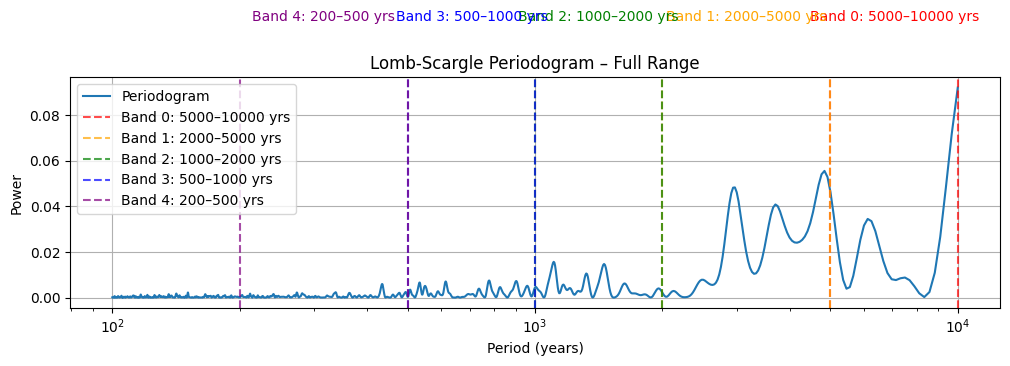

Band 0: 5000–10000 yrs
Band 1: 2000–5000 yrs
Band 2: 1000–2000 yrs
Band 3: 500–1000 yrs
Band 4: 200–500 yrs


KeyboardInterrupt: Interrupted by user

In [ ]:
# --- Start Interactive Loop -----------------------------------------------
print("Starting interactive harmonic fitting loop...")
while True:
    res, harm = fit_next_harmonic(t, res)
    if harm is None:
        break
    print("-------------------------------\n")

In [ ]:
# --- Save Results ----------------------------------------------------
if harmonics_log:
    log_df = pd.DataFrame(harmonics_log)
    log_df.to_csv("fitted_harmonics.csv", index=False)
    print(f"\n✅ Saved {len(harmonics_log)} harmonics to 'fitted_harmonics.csv'")
else:
    print("\nNo harmonics were fitted.")

In [ ]:
log_df = pd.DataFrame(harmonics_log)

In [ ]:
log_df

,iteration,P_mean,P_std,P_hpd_low,P_hpd_high,A_mean,A_std,A_hpd_low,A_hpd_high,phi_mean,phi_std,phi_hpd_low,phi_hpd_high
0,1,4181.290,155.507,3893.482,4475.667,0.102,0.025,0.056,0.151,3.312,0.455,2.454,4.182
1,2,2998.902,181.138,2674.165,3356.456,0.059,0.026,0.004,0.101,3.866,0.952,2.309,5.800
2,3,7780.595,270.352,7274.988,8301.315,0.158,0.023,0.113,0.199,3.274,0.216,2.862,3.666
3,4,983.082,282.845,313.748,1411.518,0.066,0.027,0.008,0.112,2.465,1.575,0.021,5.744
4,5,1819.666,335.362,1290.962,2440.362,0.037,0.025,0.000,0.080,3.089,1.790,0.213,6.102
5,6,1365.829,243.159,895.489,1802.650,0.052,0.026,0.000,0.093,2.772,1.938,0.000,5.928
6,7,1448.413,62.686,1361.548,1528.053,0.083,0.025,0.036,0.129,2.771,2.547,0.117,6.278
7,8,1438.078,16.772,1407.461,1469.877,0.165,0.023,0.121,0.207,4.488,2.498,0.002,6.221
8,9,1439.257,19.010,1403.790,1467.766,0.231,0.024,0.188,0.276,2.094,2.392,0.431,6.283
9,10,1453.316,5.040,1443.924,1462.746,0.317,0.023,0.275,0.359,0.063,0.057,0.000,0.168


In [8]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from scipy.signal import detrend
from statsmodels.stats.diagnostic import acorr_ljungbox
from astropy.timeseries import LombScargle

# --- Configuration Parameters ----------------------------------------------
X = 30000  # Set your desired cutoff age here

# --- Data Loading and Preprocessing ----------------------------------------
df = (
    pd.read_excel("./data/d18O NGRIP 21.04.24.xlsx",
                  sheet_name="Raw Data",
                  usecols="C:D",
                  skiprows=10, nrows=6114, names=["Age", "d18o"])
    .query("Age < @X")  # Use cutoff parameter
)

t = df["Age"].values
y = detrend(df["d18o"].values)
residual = y.copy()
max_t = X  # Use configured cutoff as maximum period

# --- Dynamic Band Configuration (10 equal intervals) -----------------------
def generate_period_boundaries(max_t):
    num_bands = 10
    periods = np.linspace(0, max_t, num_bands + 1)
    bands = []
    for i in range(num_bands):
        min_p = periods[i]
        max_p = periods[i+1]
        bands.append({
            "name": f"Band {i}: {min_p:.0f}-{max_p:.0f} yrs",
            "min_freq": 1/max_p if max_p > 0 else np.inf,
            "max_freq": 1/min_p if min_p > 0 else np.inf,
            "min_period": min_p,
            "max_period": max_p
        })
    return bands

# --- Helper Functions ------------------------------------------------------
def compute_lomb_scargle(t, y, min_freq, max_freq, samples_per_peak=10):
    frequency, power = LombScargle(t, y).autopower(
        minimum_frequency=min_freq,
        maximum_frequency=max_freq,
        samples_per_peak=samples_per_peak
    )
    return frequency, power

def find_peak_parameters(t, y, frequency, power, n_peaks=1):
    idx = np.argsort(power)[-n_peaks:][::-1]
    freq_guesses = frequency[idx]
    period_guesses = 1 / freq_guesses

    amps, phis = [], []
    for f in freq_guesses:
        X = np.column_stack([np.sin(2 * np.pi * f * t),
                             np.cos(2 * np.pi * f * t)])
        coeff, *_ = np.linalg.lstsq(X, y, rcond=None)
        a, b = coeff
        amps.append(np.hypot(a, b))
        phis.append(np.arctan2(b, a))
    return period_guesses, amps, phis

def generate_initial_values(P_init, A_init, phi_clipped, residual_std, seed=42):
    np.random.seed(seed)
    return {
        "P": np.clip(P_init + np.random.normal(0, 50), 200, 10000),
        "A": max(0.001, A_init + np.random.normal(0, 0.05)),
        "phi": np.clip(phi_clipped + np.random.normal(0, 0.1), 0.001, 2*np.pi - 0.001),
        "sigma": max(0.001, residual_std + np.random.normal(0, 0.01))
    }

# --- Core Functions --------------------------------------------------------
def estimate_initial_params(t, y, max_t, n_peaks=1):
    bands = generate_period_boundaries(max_t)
    
    all_periods = []
    all_amplitudes = []
    all_phases = []

    for band in bands:
        print(f"🔍 Scanning {band['name']}")
        frequency, power = compute_lomb_scargle(t, y, band["min_freq"], band["max_freq"])
        periods, amps, phis = find_peak_parameters(t, y, frequency, power, n_peaks)
        
        if len(periods) > 0:
            print(f"  → Best peak: P = {periods[0]:.0f} yr, A = {amps[0]:.3f}")
        else:
            print("  → No peak found")
            
        all_periods.extend(periods)
        all_amplitudes.extend(amps)
        all_phases.extend(phis)

    combined = sorted(zip(all_periods, all_amplitudes, all_phases), key=lambda x: -x[1])
    periods, amplitudes, phases = zip(*combined) if combined else ([], [], [])
    return np.array(periods), np.array(amplitudes), np.array(phases)

harmonics_log = []

def fit_next_harmonic(t, residual, max_t):
    bands = generate_period_boundaries(max_t)
    colors = plt.cm.tab10(np.linspace(0, 1, len(bands)))

    # Full periodogram plot
    frequency_full, power_full = compute_lomb_scargle(t, residual, 1/max_t, 1/100)
    
    plt.figure(figsize=(12, 3))
    plt.plot(1/frequency_full, power_full, label="Periodogram")
    plt.xscale("log")
    plt.xlabel("Period (years)")
    plt.ylabel("Power")
    iteration = len(harmonics_log) + 1  # Current iteration number
    plt.title(f"LS {iteration}")  # Simplified title with iteration
    plt.grid(True)

    for i, band in enumerate(bands):
        min_period = band["min_period"]
        max_period = band["max_period"]
        # Add vertical lines without legend labels
        plt.axvline(min_period, color=colors[i], linestyle='--', alpha=0.7)
        plt.axvline(max_period, color=colors[i], linestyle='--', alpha=0.7)
        # Annotate directly on the plot
        mid_period = np.sqrt(min_period * max_period) if min_period > 0 else max_period/2
        plt.text(mid_period, 0.12, f"Band {i}", fontsize=10, color=colors[i], 
                ha='center', va='bottom')

    # Move legend outside the plot
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()  # Prevent clipping of text
    plt.show()

    # User input with dynamic range
    print("Available frequency bands:")
    for i, band in enumerate(bands):
        print(f"{i}: {band['name']} (periods: {band['min_period']}-{band['max_period']} yrs)")
    
    while True:
        try:
            choice = int(input(f"Enter band index (0-{len(bands)-1}), or -1 to stop: "))
            if choice == -1:
                return residual, None
            if 0 <= choice < len(bands):
                break
            else:
                print(f"Invalid choice. Please enter a number between 0 and {len(bands)-1}")
        except ValueError:
            print("Please enter a valid integer")

    selected_band = bands[choice]
    frequency, power = compute_lomb_scargle(t, residual, selected_band["min_freq"], selected_band["max_freq"])
    periods, amps, phis = find_peak_parameters(t, residual, frequency, power, n_peaks=1)
    
    if not periods:
        print("No peak found.")
        return residual, None

    P_init, A_init, phi_init = periods[0], amps[0], phis[0]
    phi_clipped = np.clip(phi_init, 0.001, 2*np.pi - 0.001)

    # Plot current residual
    plt.figure(figsize=(12, 3))
    plt.plot(t, residual, label="Current Residual")
    plt.axhline(0, color="black", ls="--", lw=1)
    plt.title("Current Residual – Fitting Selected Frequency Band")
    plt.xlabel("Age (yr BP)")
    plt.ylabel("δ18O (residual)")
    plt.legend()
    plt.show()

    # Plot selected band periodogram
    plt.figure(figsize=(12, 3))
    plt.plot(1/frequency, power, label="Periodogram")
    plt.xscale("log")
    plt.axvline(P_init, color='red', linestyle='--', alpha=0.7, label="Selected Peak")
    plt.text(P_init, 0.12, "Peak", fontsize=10, color='red', ha='center', va='bottom')
    plt.title(f"Lomb-Scargle Periodogram – {selected_band['name']}")
    plt.xlabel("Period (years)")
    plt.ylabel("Power")
    plt.grid(True)
    plt.legend()
    plt.show()

    # PyMC model with parallel sampling
    with pm.Model() as mod:
        P = pm.TruncatedNormal("P", mu=P_init, sigma=300, lower=200, upper=11000)
        A = pm.HalfNormal("A", sigma=A_init*2)
        phi = pm.Uniform("phi", lower=0, upper=2*np.pi)
        sigma = pm.HalfNormal("sigma", sigma=1.0)
        mu = A * pm.math.sin(2*np.pi*t / P + phi)
        pm.Normal("obs", mu=mu, sigma=sigma, observed=residual)

        initvals = generate_initial_values(P_init, A_init, phi_clipped, np.std(residual))
        
        try:
            tr = pm.sample(
                draws=2000,
                tune=2000,
                chains=4,
                cores=4,
                target_accept=0.97,
                initvals=[initvals] * 4,
                progressbar=True
            )
        except pm.SamplingError as e:
            print("Sampling failed.")
            return residual, None

    summary = az.summary(tr)
    harmonics_log.append({
        "iteration": len(harmonics_log) + 1,
        "P_mean": summary.loc["P", "mean"],
        "P_std": summary.loc["P", "sd"],
        "A_mean": summary.loc["A", "mean"],
        "A_std": summary.loc["A", "sd"],
        "phi_mean": summary.loc["phi", "mean"],
        "phi_std": summary.loc["phi", "sd"],
    })

    P_hat = summary.loc["P", "mean"]
    A_hat = summary.loc["A", "mean"]
    phi_hat = summary.loc["phi", "mean"]

    residual -= A_hat * np.sin(2*np.pi*t / P_hat + phi_hat)

    # Diagnostics and plots
    print("\nPosterior Summary:")
    print(summary)
    print(f"\nFitted Wave: P = {P_hat:.1f} ± {summary.loc['P', 'sd']:.2f} yr")
    print(f"              A = {A_hat:.3f} ± {summary.loc['A', 'sd']:.3f}")
    print(f"              φ = {phi_hat:.2f} rad")

    plt.figure(figsize=(12, 3))
    plt.plot(t, residual, label="Updated Residual")
    plt.axhline(0, color="black", ls="--", lw=1)
    plt.title("Residual After Fitting Selected Harmonic")
    plt.xlabel("Age (yr BP)")
    plt.ylabel("δ18O (residual)")
    plt.legend()
    plt.ylim(-2, 2)
    plt.show()

    pvals = acorr_ljungbox(residual, lags=[10, 50, 100], return_df=True)["lb_pvalue"]
    if (pvals > 0.05).all():
        print("\n✅ Residual looks like white noise. Consider stopping.")

    return residual, (P_hat, A_hat, phi_hat)

In [7]:
res= residual

Starting interactive harmonic fitting loop...


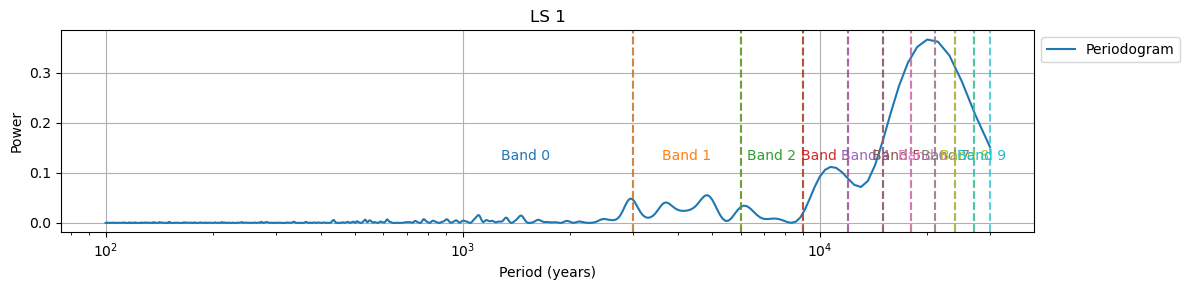

Available frequency bands:
0: Band 0: 0-3000 yrs (periods: 0.0-3000.0 yrs)
1: Band 1: 3000-6000 yrs (periods: 3000.0-6000.0 yrs)
2: Band 2: 6000-9000 yrs (periods: 6000.0-9000.0 yrs)
3: Band 3: 9000-12000 yrs (periods: 9000.0-12000.0 yrs)
4: Band 4: 12000-15000 yrs (periods: 12000.0-15000.0 yrs)
5: Band 5: 15000-18000 yrs (periods: 15000.0-18000.0 yrs)
6: Band 6: 18000-21000 yrs (periods: 18000.0-21000.0 yrs)
7: Band 7: 21000-24000 yrs (periods: 21000.0-24000.0 yrs)
8: Band 8: 24000-27000 yrs (periods: 24000.0-27000.0 yrs)
9: Band 9: 27000-30000 yrs (periods: 27000.0-30000.0 yrs)


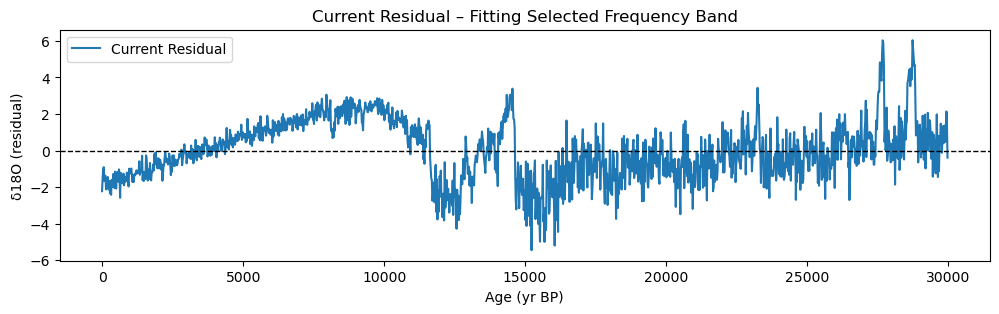

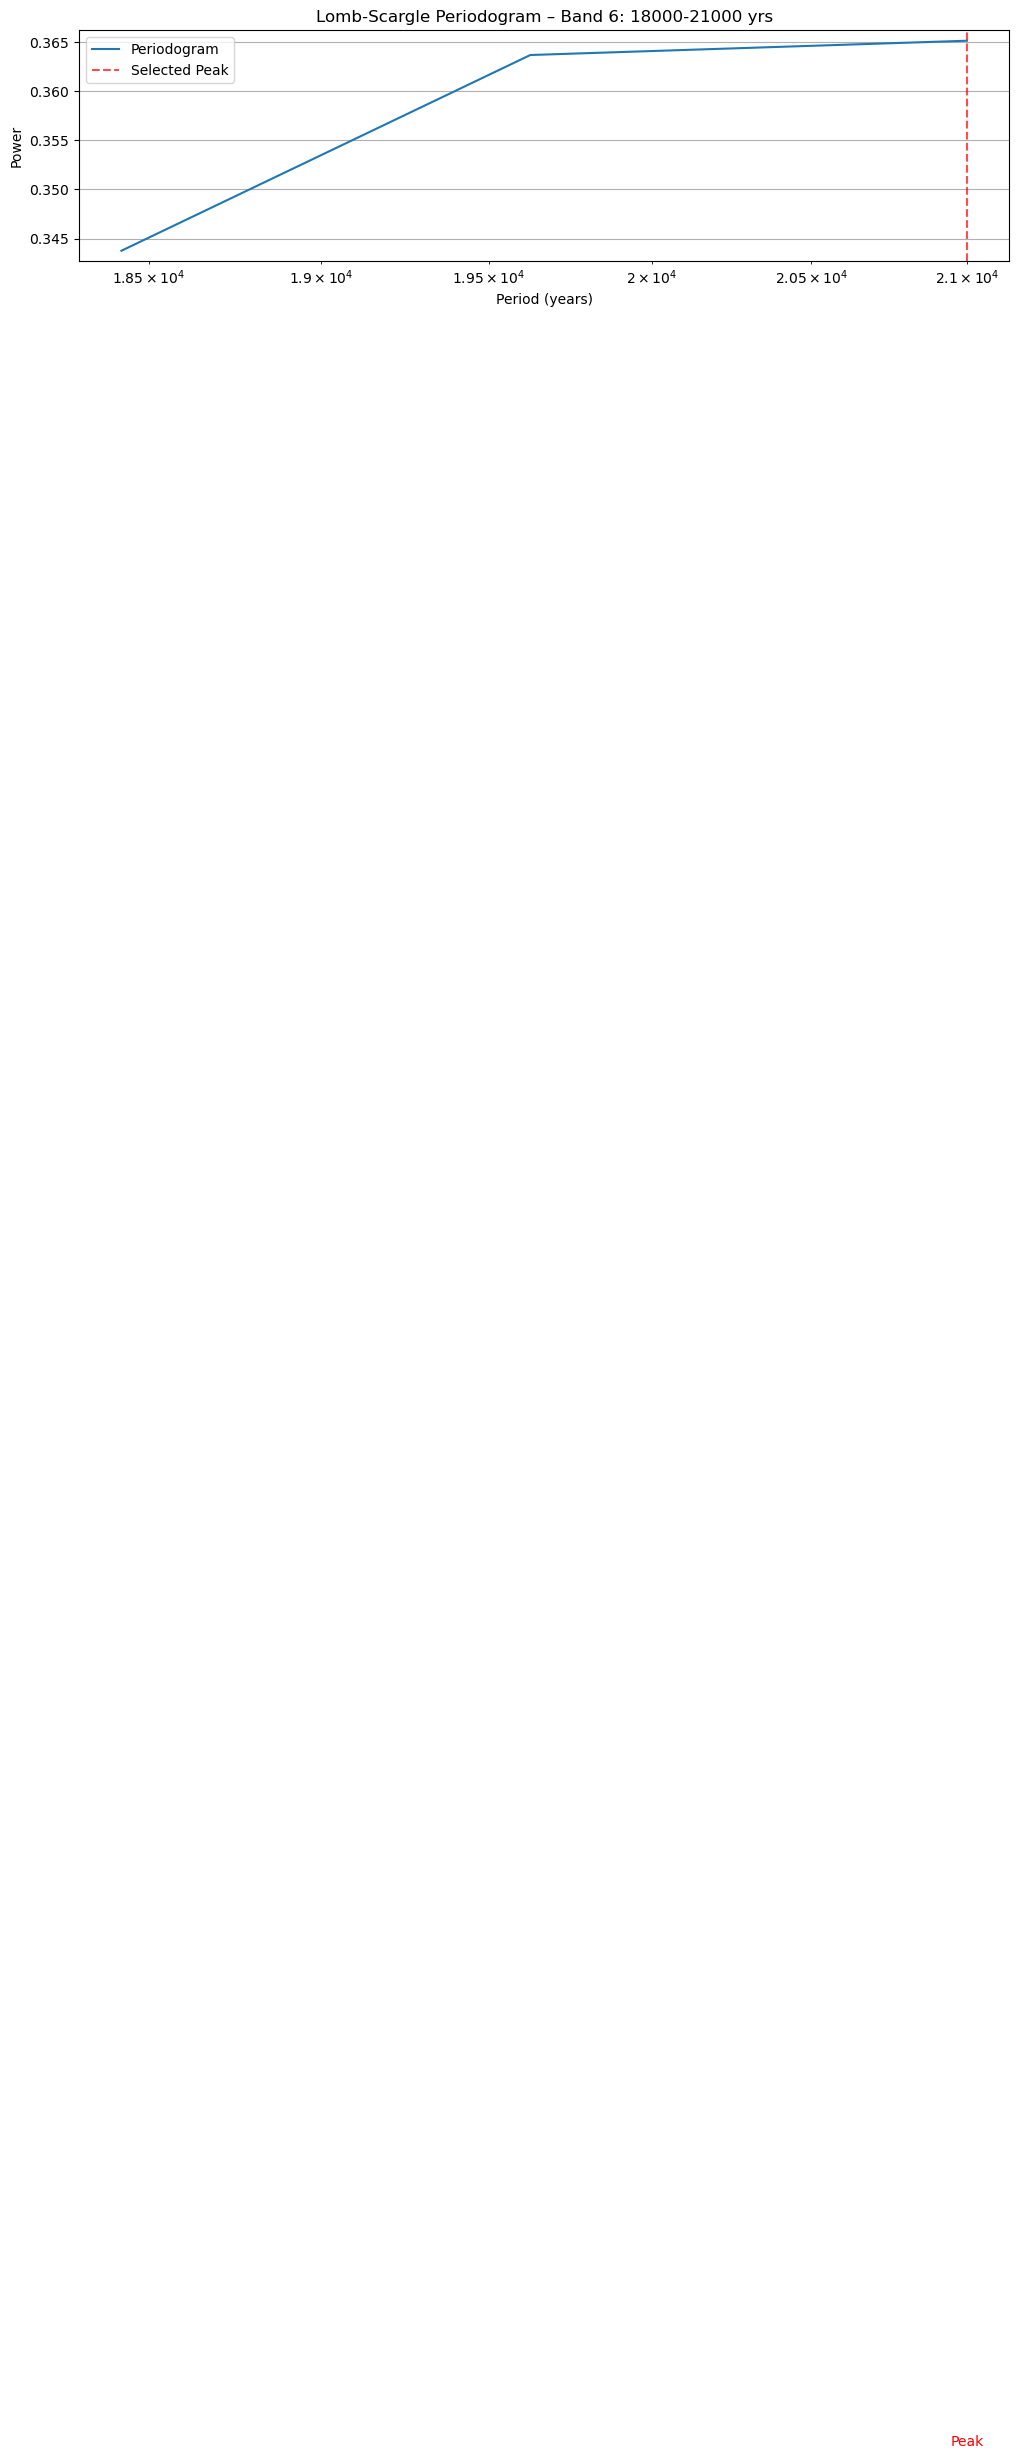

Initializing NUTS using jitter+adapt_diag...
c:\Users\franc\anaconda3\Lib\site-packages\pytensor\tensor\elemwise.py:731: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
c:\Users\franc\anaconda3\Lib\site-packages\pytensor\tensor\elemwise.py:731: RuntimeWarning: overflow encountered in exp
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
c:\Users\franc\anaconda3\Lib\site-packages\pytensor\tensor\elemwise.py:731: RuntimeWarning: invalid value encountered in subtract
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
c:\Users\franc\anaconda3\Lib\site-packages\pytensor\tensor\rewriting\elemwise.py:1011: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [P, A, phi, sigma]


Output()

In [ ]:
# --- Interactive Loop ------------------------------------------------------
print("Starting interactive harmonic fitting loop...")
while True:
    res, harm = fit_next_harmonic(t, res, max_t)
    if harm is None:
        break
    print("-------------------------------\n")